In [ ]:
!git clone https://github.com/ArminMasoumian/GCNDepth.git
%cd GCNDepth
!pip install numpy pandas matplotlib scikit-image scipy imageio tqdm cython mmcv==0.4.4 torch "torchvision>=0.4.0" pypng

from IPython.display import clear_output
clear_output()

In [ ]:
%cd /content/GCNDepth

from __future__ import absolute_import, division, print_function
import os
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
from mmcv import Config

import torch
from torch.utils.data import DataLoader

sys.path.append('.')
sys.path.append('..')
from mono.model.registry import MONO
from mono.model.mono_baseline.layers import disp_to_depth
from mono.datasets.utils import readlines
from mono.datasets.kitti_dataset import KITTIRAWDataset

cv2.setNumThreads(0)  # This speeds up evaluation 5x on our unix systems (OpenCV 3.3.1)

MIN_DEPTH = 1e-3
MAX_DEPTH = 80
SCALE = 36 #we set baseline=0.0015m which is 36 times smaller than the actual value (0.54m)

def transform(cv2_img, height=320, width=1024):
    im_tensor = torch.from_numpy(cv2_img.astype(np.float32)).cuda().unsqueeze(0)
    im_tensor = im_tensor.permute(0, 3, 1, 2).contiguous()
    im_tensor = torch.nn.functional.interpolate(im_tensor, [height, width],mode='bilinear', align_corners=False)
    im_tensor /= 255
    return im_tensor

def predict(cv2_img, model):
    original_height, original_width = cv2_img.shape[:2]
    im_tensor = transform(cv2_img)

    with torch.no_grad():
        input = {}
        input['color_aug', 0, 0] = im_tensor
        outputs = model(input)

    disp = outputs[("disp", 0, 0)]
    disp_resized = torch.nn.functional.interpolate(disp, (original_height, original_width), mode="bilinear", align_corners=False)
    min_disp = 1/MAX_DEPTH
    max_disp = 1/MIN_DEPTH
    depth = 1/(disp_resized.squeeze().cpu().numpy()*max_disp + min_disp) * SCALE
    return depth, disp_resized.squeeze().cpu().numpy()

def evaluate(cfg_path, model_path, img_path):
    with torch.no_grad():
        cv2_img = cv2.imread(img_path)
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)

        depth, disp_resized = predict(cv2_img, model)

    return depth


cfg_path = '/content/GCNDepth/config/cfg_kitti_fm.py' # path to cfg file
model_path = '/content/drive/MyDrive/Colab Notebooks/depth-estimation/GCNDepth/epoch_20.pth' # path to model weight
cfg = Config.fromfile(cfg_path)
cfg['model']['depth_pretrained_path'] = None
cfg['model']['pose_pretrained_path'] = None
cfg['model']['extractor_pretrained_path'] = None
model = MONO.module_dict[cfg.model['name']](cfg.model)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'], strict=True)
model.cuda()
model.eval()

from IPython.display import clear_output
clear_output()

In [ ]:
# helper functions
import os

MAX_RANGE = MAX_DEPTH

outdoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/outdoor/*/*/*.png'
indoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/indoors/*/*/*.png'
nyu_folder_path = '/content/drive/MyDrive/PW/Praca/NYUv2/rgb/*.jpg'
stray_folder_path = '/content/drive/MyDrive/PW/Praca/stray_dataset/*/first_frame.png'
stray_indoor_folder_path = '/content/drive/MyDrive/PW/Praca/stray_indoor/*/first_frame.png'
kitti_folder_path = '/content/drive/MyDrive/PW/Praca/kitti_evaluation/image/*.png'
vkitti2_folder_path = '/content/drive/MyDrive/PW/Praca/vkitti2_evaluation/vkitti_2.0.3_rgb/*/15-deg-left/frames/rgb/Camera_0/*.jpg'
taskonomy_folder_path = '/content/drive/MyDrive/PW/Praca/Taskonomy/rgb/allensville/*.png'
actual_path = indoor_folder_path

def get_gt_path(image_path):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        gt_path = image_path.replace('.png', '_depth.npy')
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        gt_path = image_path.replace('first_frame.png', 'depth/000000.png')
    elif actual_path == nyu_folder_path:
        dir_name, image_name = os.path.split(image_path)
        gt_path = os.path.join(dir_name.replace('rgb', 'depth'), image_name.replace('jpg', 'npy'))
    elif actual_path == vkitti2_folder_path:
        gt_path = image_path.replace('rgb', 'depth').replace('jpg', 'png')
    elif actual_path == kitti_folder_path:
        gt_path = image_path.replace('image', 'groundtruth_depth', 2)
    elif actual_path == taskonomy_folder_path:
        gt_path = image_path.replace('rgb', 'depth_euclidean')
    return gt_path

def get_error_mask(gt):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        if MAX_RANGE:
            mask = (gt > 0.6) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0.6) & (gt < 350)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        mask = (gt > 0.3) & (gt < 5)
    elif actual_path == nyu_folder_path:
        mask = (gt > 0) & (gt < 10)
    elif actual_path == vkitti2_folder_path:
        if MAX_RANGE:
            mask = (gt > 2.5) & (gt < MAX_RANGE)
        else:
            mask = (gt > 2.5) & (gt < 85)
    elif actual_path == kitti_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0)
    elif actual_path == taskonomy_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0) & (gt < 128)
    return mask

def get_depth_gt(gt_path):
    if actual_path in [outdoor_folder_path, indoor_folder_path]:
        depth_gt = np.load(gt_path).squeeze()
    elif actual_path == nyu_folder_path:
        depth_gt = np.load(gt_path)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        depth_gt = cv2.imread(gt_path, -1) / 1000
    elif actual_path == vkitti2_folder_path:
        depth_gt = cv2.imread(gt_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 100
    elif actual_path == kitti_folder_path:
        depth_gt = cv2.imread(gt_path, 0)
    elif actual_path == taskonomy_folder_path:
        depth_gt = cv2.imread(gt_path, -1) / 512
    return depth_gt

def compute_errors(gt, pred):
    mask = get_error_mask(gt)
    gt = gt[mask]
    pred = pred[mask]

    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean((np.abs(gt - pred) / gt))
    sq_rel = np.mean((((gt - pred) ** 2) / gt))

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = (np.log(pred) - np.log(gt))
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)

In [ ]:
from tqdm import tqdm
import glob, time

results = []
images = [i for i in glob.iglob(actual_path, recursive=True)]
for image_path in tqdm(images):
    gt_path = get_gt_path(image_path)
    start_time = time.time()

    pred_depth = evaluate(cfg_path, model_path, image_path) * 100

    exec_time = (time.time() - start_time)
    if actual_path in [stray_folder_path, stray_indoor_folder_path]:
        pred_depth = cv2.resize(pred_depth, (256, 192))
    results.append({'pred_depth': pred_depth, 'gt_path': gt_path, 'exec_time': exec_time})

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


In [ ]:
import numpy as np
import cv2

# compute errors on results
metrics = []
print("computing errors...")
for result in tqdm(results):
    depth_gt = get_depth_gt(result['gt_path'])
    metrics.append({"exec_time": result['exec_time'], **compute_errors(depth_gt, result['pred_depth'])})

# compute mean values
values_list = {
    "a1": [],
    "a2": [],
    "a3": [],
    "abs_rel": [],
    "rmse": [],
    "log_10": [],
    "rmse_log": [],
    "silog": [],
    "sq_rel": [],
    "exec_time": [],
}
for metric in metrics:
    for key, value in metric.items():
        values_list[key].append(value)

mean_values = {}
for key, value in values_list.items():
    mean_values[key] = sum(value) / len(value)

print('\n', mean_values)

computing errors...


100%|██████████| 19/19 [00:14<00:00,  1.34it/s]


 {'a1': 0.020515853281236684, 'a2': 0.14113344714986614, 'a3': 0.35043383974177805, 'abs_rel': 1.7360347018517517, 'rmse': 7.558607117065873, 'log_10': 0.3764282327837302, 'rmse_log': 0.9419144166211527, 'silog': 34.67027256636938, 'sq_rel': 30.214317463995645, 'exec_time': 1.2662120116384405}


0
21.832586


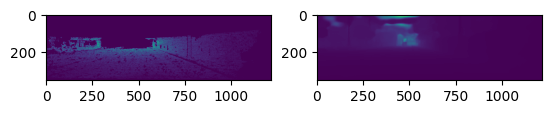

In [ ]:
# debug set

num = 5
y, x = (10, 10)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

print(gt_depth[y][x])
print(pred_depth[y][x])

import matplotlib.pyplot as plt
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(gt_depth)
f.add_subplot(1,2, 2)
plt.imshow(pred_depth)
plt.show(block=True)

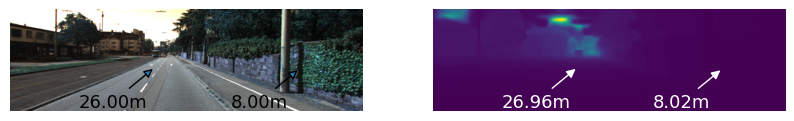

In [ ]:
# KITTI visualisation

num = 4
y, x = (205, 1000)
y2, x2 = (200, 500)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('groundtruth_depth', 'image', 2)

fontsize = 13
xytext1 = (-50, -24)
xytext2 = (-55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

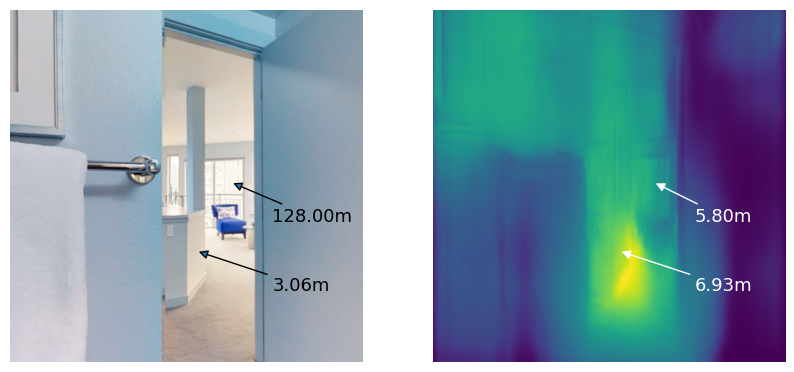

In [ ]:
# Taskonomy visualisation

num = 9
y, x = (250, 320)
y2, x2 = (350, 270)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

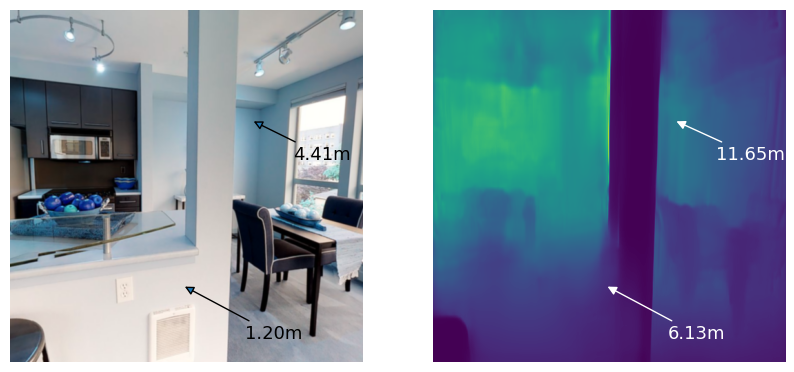

In [ ]:
# Taskonomy visualisation

num = 3
y, x = (160, 350)
y2, x2 = (400, 250)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (45, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

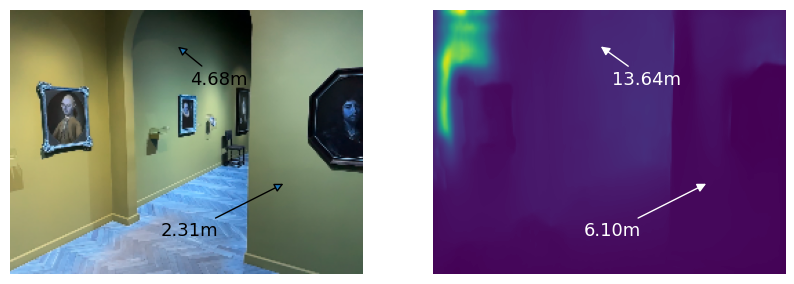

In [ ]:
# Stray indoor visualisation

num = 7
y, x = (25, 120)
y2, x2 = (125, 200)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (10, -25)
xytext2 = (-90, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

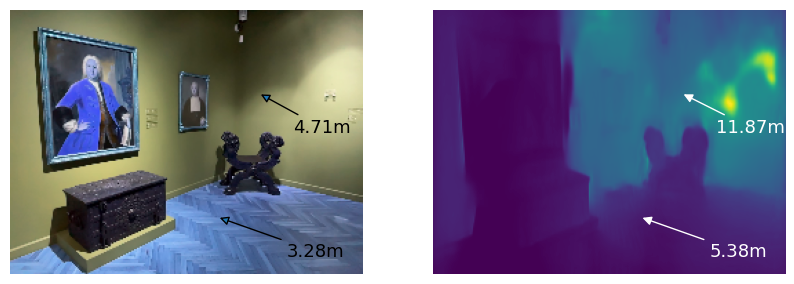

In [ ]:
# Stray indoor visualisation

num = 9
y, x = (60, 180)
y2, x2 = (150, 150)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (25, -25)
xytext2 = (50, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

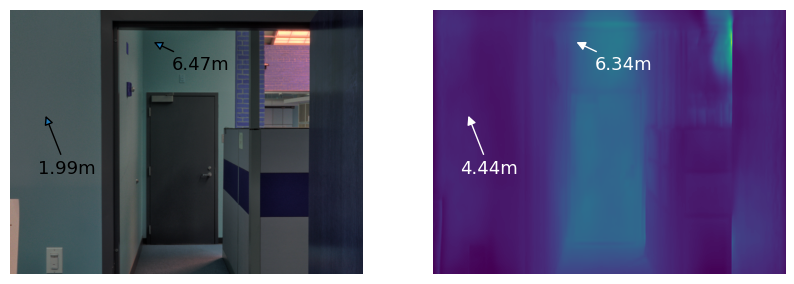

In [ ]:
# DIODE indoor visualisation

num = 1
y, x = (300, 100)
y2, x2 = (90, 410)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('_depth.npy', '.png')

fontsize = 13
xytext1 = (-5, -40)
xytext2 = (15, -17)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)